In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os

%matplotlib inline

# Network Setup

Set up the neural network and training operations

In [2]:
class Conv_Net:
    def __init__(self, image_height, image_width, channels, num_classes):
        
        self.input_layer = tf.placeholder(dtype=tf.float32, shape=[None, image_height, image_width, channels], name="inputs")
        print(self.input_layer.shape)
        
        conv_layer_1 = tf.layers.conv2d(self.input_layer, filters = 32, kernel_size=[5,5], padding="same", activation=tf.nn.relu)
        print(conv_layer_1.shape)
        
        pooling_layer_1 = tf.layers.max_pooling2d(conv_layer_1, pool_size=[2,2], strides=2)
        print(pooling_layer_1.shape)
        
        conv_layer_2 = tf.layers.conv2d(pooling_layer_1, filters = 64, kernel_size=[5,5], padding="same", activation=tf.nn.relu)
        print(conv_layer_2.shape)
        
        pooling_layer_2 = tf.layers.max_pooling2d(conv_layer_2, pool_size=[2,2], strides = 2)
        print(pooling_layer_2.shape)
        
        flattened_pooling = tf.layers.flatten(pooling_layer_2)
        dense_layer = tf.layers.dense(flattened_pooling, 1024, activation=tf.nn.relu)
        print(dense_layer.shape)
        
        dropout = tf.layers.dropout(dense_layer, rate=0.4, training=True)
        print(dropout.shape)
        
        outputs = tf.layers.dense(dropout, num_classes)
        print(outputs.shape)
        
        self.choice = tf.argmax(outputs, axis=1)
        self.probability = tf.nn.softmax(outputs)
        
        self.labels = tf.placeholder(dtype=tf.float32, name="labels")
        
        self.accuracy, self.accuracy_op = tf.metrics.accuracy(self.labels, self.choice)
        
        one_hot_labels = tf.one_hot(indices=tf.cast(self.labels, dtype=tf.int32), depth=10)
        
        self.loss = tf.losses.softmax_cross_entropy(onehot_labels=one_hot_labels, logits=outputs)
        
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-2)
        self.train_operation = optimizer.minimize(loss=self.loss, global_step=tf.train.get_global_step())
        

# Load the data

Load the mnist data into a Dataset object.

In [3]:
image_height = 28
image_width = 28

color_channels = 1

model_name = "mnist"

mnist = tf.contrib.learn.datasets.load_dataset("mnist")

train_data = mnist.train.images
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)

eval_data = mnist.test.images
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

print(train_data.shape)

reshaped_data = np.reshape(train_data, [-1, image_height, image_width, color_channels])

print(reshaped_data.shape)

reshaped_eval = np.reshape(eval_data, [-1, image_height, image_width, color_channels])

 

Extracting MNIST-data\train-images-idx3-ubyte.gz


Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


(55000, 784)
(55000, 28, 28, 1)


In [3]:
image_height = 32
image_width = 32

color_channels = 3

model_name = "cifar"

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

cifar_path = './cifar-10-data/'

train_data = np.array([])
train_labels = np.array([])

# Load all the data batches
for i in range(1,6):
    data_batch = unpickle(cifar_path + 'data_batch_' + str(i))
    train_data = np.append(train_data, data_batch[b'data'])
    train_labels = np.append(train_labels, data_batch[b'labels'])


# Load the eval batch
eval_batch = unpickle(cifar_path + 'test_batch')

eval_data = eval_batch[b'data']
eval_labels = eval_batch[b'labels'] 

print(train_data.shape)

def process_images(data):
    # convert to floats
    float_data = np.array(data, dtype=float) / 255.0
    
    reshaped_images = float_data.reshape([-1, color_channels, image_height, image_width])
    # reorder indices to match our nn:
    reordered_images = reshaped_images.transpose([0,2,3,1])
    
    return reordered_images

reshaped_data = process_images(train_data)

print(reshaped_data.shape)

reshaped_eval = process_images(eval_data)

category_names = unpickle(cifar_path + 'batches.meta')[b'label_names']
print(category_names)

train_data = []
eval_data = []

(153600000,)


(50000, 32, 32, 3)


[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


In [4]:
training_steps = 20000
batch_size = 100
path = "./" + model_name + "-cnn/"

load_checkpoint = False

In [5]:
# Training loop
tf.reset_default_graph()

training_dataset = tf.data.Dataset.from_tensor_slices((reshaped_data, train_labels))
    
batch_dataset = training_dataset.batch(batch_size)

batch_iterator = batch_dataset.make_initializable_iterator()
next_element = batch_iterator.get_next()

print(batch_dataset)

cnn = Conv_Net(image_height,image_width,color_channels,10)

# These get pretty huge
saver = tf.train.Saver(max_to_keep=2)

if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    
    if load_checkpoint:
        checkpoint = tf.train.get_checkpoint_state(path)
        saver.restore(sess, checkpoint.model_checkpoint_path)
    else:
        sess.run(tf.global_variables_initializer())
    
    sess.run(tf.local_variables_initializer())
    
    sess.run(batch_iterator.initializer)
    
    for i in range(training_steps):
        try:
            current_batch = sess.run(next_element)
        except tf.errors.OutOfRangeError:
            sess.run(batch_iterator.initializer)
            current_batch = sess.run(next_element)
        
        batch_inputs = current_batch[0]
        batch_labels = current_batch[1]
        
        sess.run((cnn.train_operation, cnn.accuracy_op), feed_dict={ cnn.input_layer:batch_inputs, cnn.labels:batch_labels})
        
        if i % 1000 == 0 and i > 0:
            current_acc = sess.run(cnn.accuracy, feed_dict={ cnn.input_layer:batch_inputs, cnn.labels:batch_labels})
            print("Accuracy at step " + str(i) + ": " + str(current_acc))
            print("Saving checkpoint")
            saver.save(sess, path + model_name, i)
            
    print("Saving final checkpoint for training session.")
    saver.save(sess, path + model_name, i)

<BatchDataset shapes: ((?, 32, 32, 3), (?,)), types: (tf.float64, tf.float64)>
(?, 32, 32, 3)
(?, 32, 32, 32)
(?, 16, 16, 32)
(?, 16, 16, 64)
(?, 8, 8, 64)
(?, 1024)
(?, 1024)
(?, 10)


Accuracy at step 1000: 0.308491
Saving checkpoint


Accuracy at step 2000: 0.372674
Saving checkpoint


Accuracy at step 3000: 0.41029
Saving checkpoint


Accuracy at step 4000: 0.438563
Saving checkpoint


Accuracy at step 5000: 0.461324
Saving checkpoint


Accuracy at step 6000: 0.480857
Saving checkpoint


Accuracy at step 7000: 0.498612
Saving checkpoint


Accuracy at step 8000: 0.514683
Saving checkpoint


Accuracy at step 9000: 0.529716
Saving checkpoint


Accuracy at step 10000: 0.543418
Saving checkpoint


Accuracy at step 11000: 0.556275
Saving checkpoint


Accuracy at step 12000: 0.56854
Saving checkpoint


Accuracy at step 13000: 0.580276
Saving checkpoint


Accuracy at step 14000: 0.591299
Saving checkpoint


Accuracy at step 15000: 0.601837
Saving checkpoint


Accuracy at step 16000: 0.612031
Saving checkpoint


Accuracy at step 17000: 0.621804
Saving checkpoint


Accuracy at step 18000: 0.631324
Saving checkpoint


Accuracy at step 19000: 0.640471
Saving checkpoint


Saving final checkpoint for training session.


INFO:tensorflow:Restoring parameters from ./cifar-cnn/cifar-19999


10000
10000


0.6728


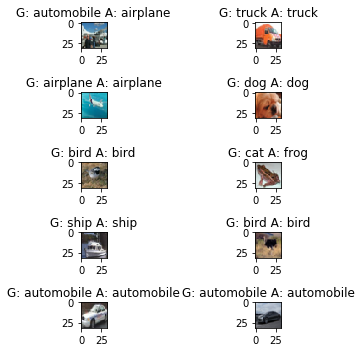

In [6]:
# Evaluate the network

with tf.Session() as sess:
    checkpoint = tf.train.get_checkpoint_state(path)
    saver.restore(sess,checkpoint.model_checkpoint_path)
    
    sess.run(tf.local_variables_initializer())
    
    print(len(reshaped_eval))
    print(len(eval_labels))
    
    #accuracy overall
    print(sess.run( cnn.accuracy_op, feed_dict={cnn.input_layer:reshaped_eval, cnn.labels:eval_labels}))
    
    indexes = np.random.choice(len(reshaped_eval), 10, replace=False)
    
    rows = 5
    cols = 2
    
    fig, axes = plt.subplots(rows, cols, figsize=(5,5))
    fig.patch.set_facecolor('white')
    image_count = 0
    
    for idx in indexes:
        image_count += 1
        sub = plt.subplot(rows,cols,image_count)
        img = reshaped_eval[idx]
        if model_name == "mnist":
            img = img.reshape(28, 28)
        plt.imshow(img)
        guess = sess.run(cnn.choice, feed_dict={cnn.input_layer:[reshaped_eval[idx]]})
        if model_name == "mnist":
            guess_name = str(guess[0])
            actual_name = str(eval_labels[idx])
        else:
            guess_name = category_names[guess[0]].decode('utf-8')
            actual_name = category_names[eval_labels[idx]].decode('utf-8')
        sub.set_title("G: " + guess_name + " A: " + actual_name)
    plt.tight_layout()

In [169]:
plt.show()

In [70]:
sess.close()